 Make the necessary imports:

In [69]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization

from keras.callbacks import ModelCheckpoint

Mount on google

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load the Dataset

For this Python project, we’ll use the 24 Actors dataset; this is the Ryerson Audio-Visual Database of Emotional Speech and Song dataset, and is free to download. This dataset has 7356 files rated by 247 individuals 10 times on emotional validity, intensity, and genuineness. The entire dataset is 24.8GB from 24 actors, but we’ve lowered the sample rate on all the files

In [16]:
paths = []
labels = []
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Task-2/Tess'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
    if len(paths) == 2800:
        break
print('Dataset is Loaded')

Dataset is Loaded


In [17]:
print(len(paths))
print(paths[:5])
print(labels[:5])

2800
['/content/drive/MyDrive/Task-2/Tess/YAF_sad/YAF_bone_sad.wav', '/content/drive/MyDrive/Task-2/Tess/YAF_sad/YAF_bar_sad.wav', '/content/drive/MyDrive/Task-2/Tess/YAF_sad/YAF_beg_sad.wav', '/content/drive/MyDrive/Task-2/Tess/YAF_sad/YAF_back_sad.wav', '/content/drive/MyDrive/Task-2/Tess/YAF_sad/YAF_bite_sad.wav']
['sad', 'sad', 'sad', 'sad', 'sad']


In [18]:
# Paths for data.
Ravdess = "/content/drive/MyDrive/Task-2/speech-emotion-recognition-ravdess-data"
Crema ="/content/drive/MyDrive/Task-2/Crema"
Tess = "/content/drive/MyDrive/Task-2/Tess"
Savee = "/content/drive/MyDrive/Task-2/Savee"

Load the Dataset

In [19]:
## Create a dataframe
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

,speech,label
0,/content/drive/MyDrive/Task-2/Tess/YAF_sad/YAF...,sad
1,/content/drive/MyDrive/Task-2/Tess/YAF_sad/YAF...,sad
2,/content/drive/MyDrive/Task-2/Tess/YAF_sad/YAF...,sad
3,/content/drive/MyDrive/Task-2/Tess/YAF_sad/YAF...,sad
4,/content/drive/MyDrive/Task-2/Tess/YAF_sad/YAF...,sad


In [20]:
df['label'].value_counts()

sad        400
ps         400
fear       400
happy      400
neutral    400
angry      400
disgust    400
Name: label, dtype: int64

In [21]:
df.label.unique()

array(['sad', 'ps', 'fear', 'happy', 'neutral', 'angry', 'disgust'],
      dtype=object)

Exploratory Data Analysis

<Axes: xlabel='label', ylabel='count'>

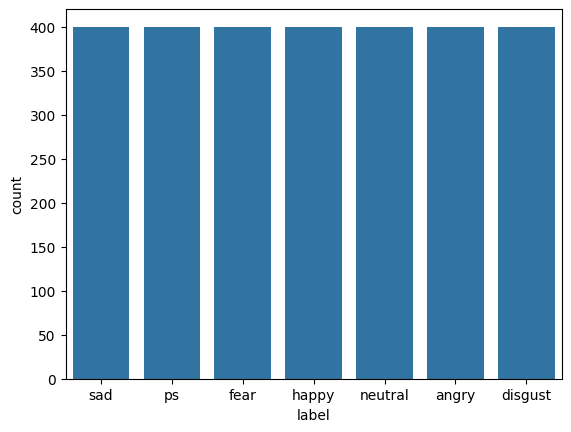

In [22]:
sns.countplot(data=df, x='label')

In [23]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

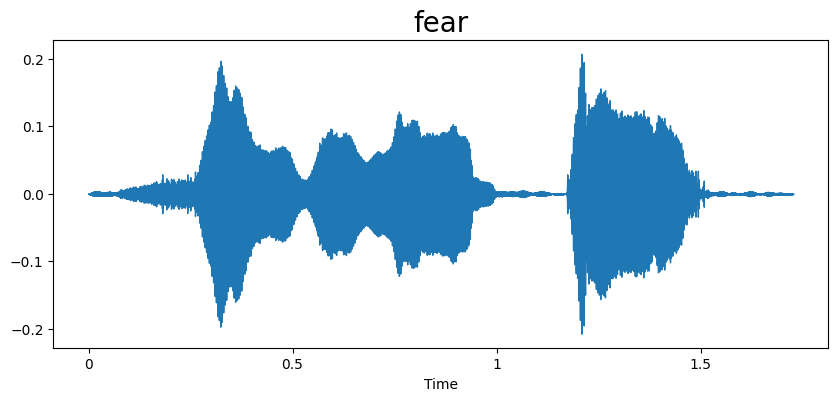

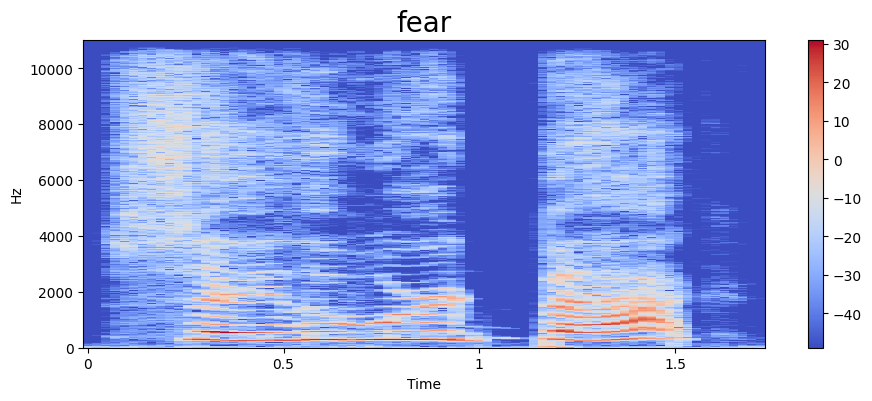

In [24]:
emotion = 'fear'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

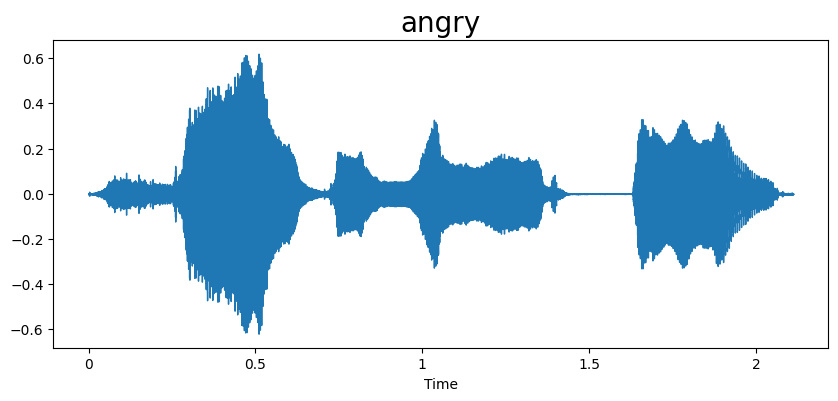

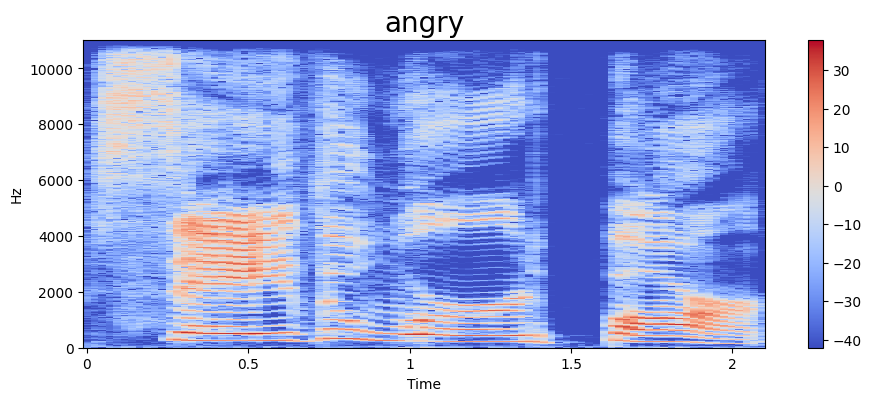

In [25]:
emotion = 'angry'
path = np.array(df['speech'][df['label']==emotion])[1]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

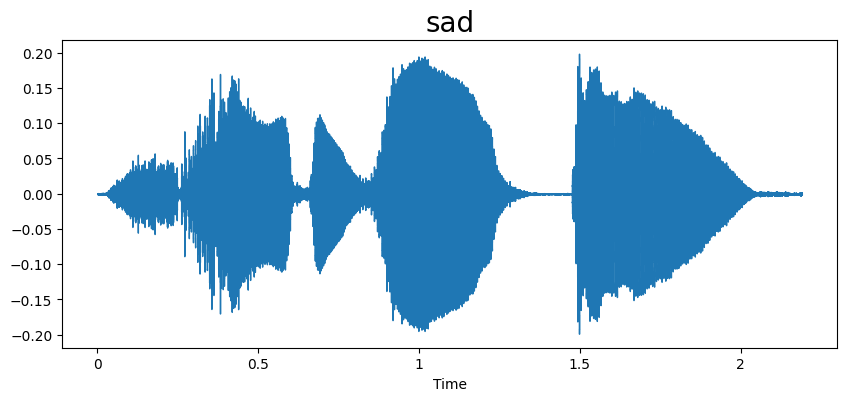

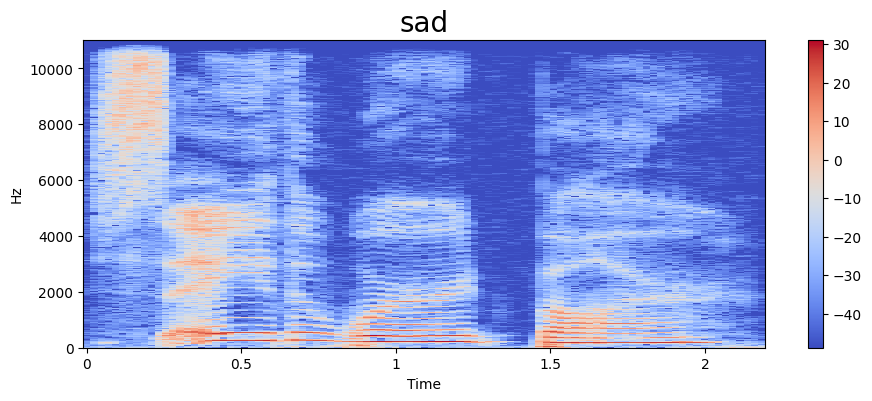

In [26]:
emotion = 'sad'
path = np.array(df['speech'][df['label']==emotion])[1]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

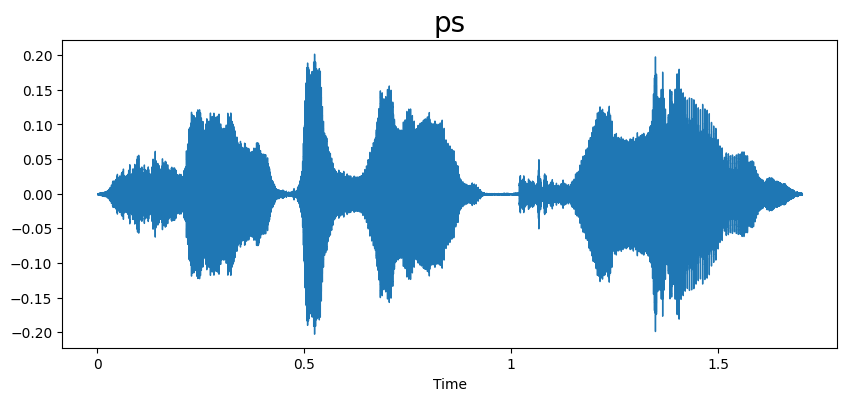

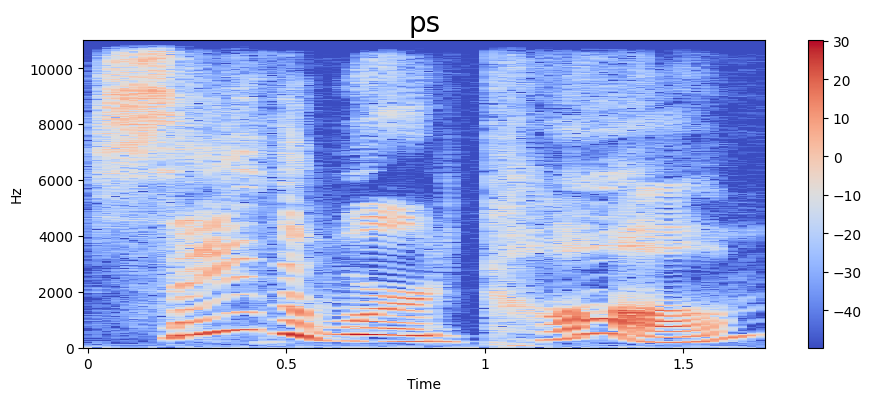

In [27]:
emotion = 'ps'
path = np.array(df['speech'][df['label']==emotion])[1]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

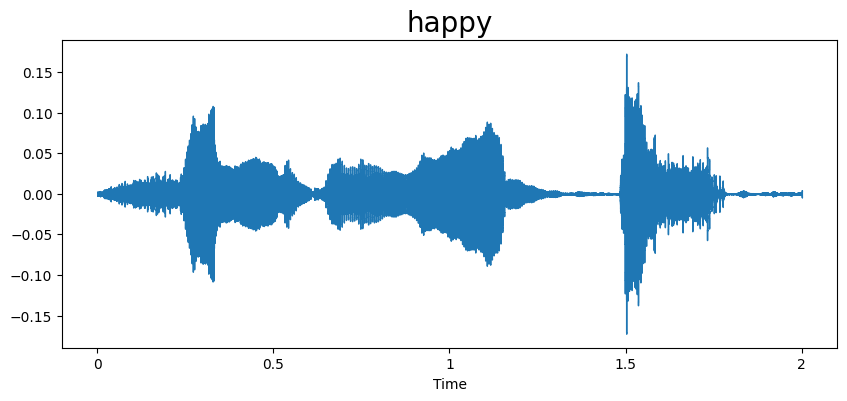

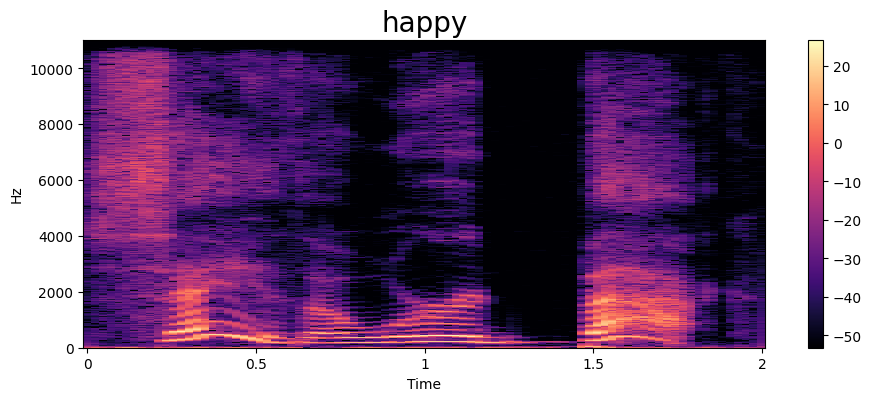

In [31]:
emotion = 'happy'
path = np.array(df['speech'][df['label']==emotion])[1]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

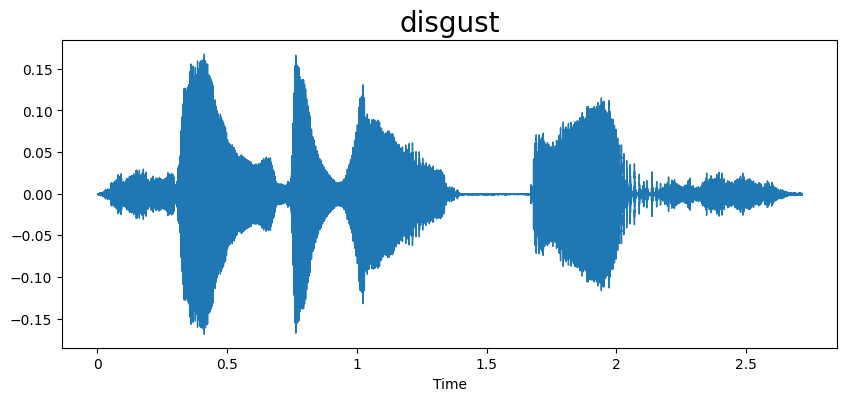

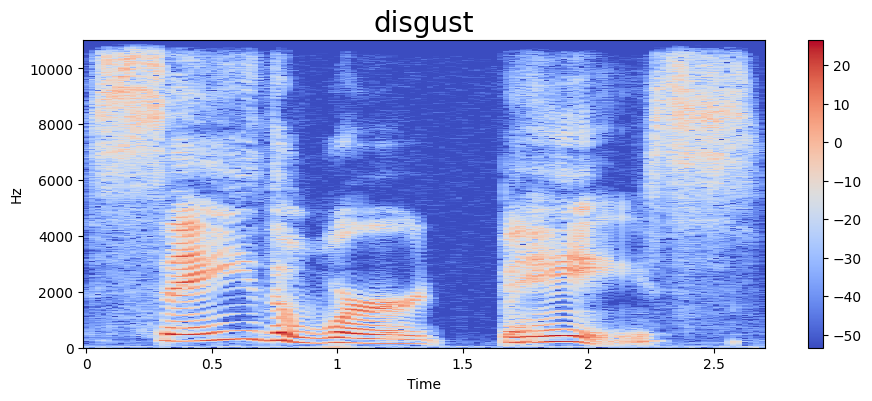

In [32]:
emotion = 'disgust'
path = np.array(df['speech'][df['label']==emotion])[1]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

mfcc: Mel Frequency Cepstral Coefficient, represents the short-term power spectrum of a sound

In [33]:
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    return mfcc

In [34]:
extract_mfcc(df['speech'][0])

array([-4.27889557e+02,  1.11618225e+02,  3.15030766e+01,  3.18502483e+01,
        4.45114040e+00,  1.62448082e+01,  6.74070930e+00, -1.65567245e+01,
        5.66905451e+00, -7.20294094e+00, -5.17142057e+00, -2.20476389e+00,
       -8.94921112e+00,  9.00503349e+00, -6.54508305e+00,  6.90415084e-01,
        4.18817848e-01, -4.89057302e+00, -3.60782075e+00, -5.82673311e+00,
       -5.94607735e+00, -8.06733894e+00, -8.47742939e+00,  4.22039986e+00,
       -1.69765019e+00,  6.72037077e+00, -1.59601188e+00, -4.84941196e+00,
       -3.47141099e+00, -3.58782125e+00, -1.62143731e+00,  1.18874550e+01,
        7.91357088e+00,  9.63916206e+00,  5.96135759e+00,  6.07998800e+00,
        6.57818747e+00,  7.85023165e+00,  1.04019518e+01,  1.05001049e+01],
      dtype=float32)

In [35]:
X_mfcc = df['speech'].apply(lambda x: extract_mfcc(x))
# X_mfcc

In [36]:
X = [x for x in X_mfcc]
X = np.array(X)
X.shape

(2800, 40)

# Input split

In [40]:

X = np.expand_dims(X, -1)
X.shape

(2800, 40, 1)

In [41]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y = enc.fit_transform(df[['label']])

In [42]:
y = y.toarray()
y.shape

(2800, 7)

# splitting data

In [71]:

x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2100, 40, 1), (2100, 7), (700, 40, 1), (700, 7))

# Seqential Model:

In [73]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=7, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 40, 256)           1536      
                                                                 
 max_pooling1d_14 (MaxPooli  (None, 20, 256)           0         
 ng1D)                                                           
                                                                 
 conv1d_13 (Conv1D)          (None, 20, 256)           327936    
                                                                 
 max_pooling1d_15 (MaxPooli  (None, 10, 256)           0         
 ng1D)                                                           
                                                                 
 conv1d_14 (Conv1D)          (None, 10, 128)           163968    
                                                                 
 max_pooling1d_16 (MaxPooli  (None, 5, 128)          

In [74]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
33/33 [==============================] - 7s 152ms/step - loss: 3.6519 - accuracy: 0.1595 - val_loss: 1.8430 - val_accuracy: 0.3329 - lr: 0.0010
Epoch 2/50
33/33 [==============================] - 6s 187ms/step - loss: 1.7992 - accuracy: 0.2381 - val_loss: 1.4781 - val_accuracy: 0.4229 - lr: 0.0010
Epoch 3/50
33/33 [==============================] - 4s 135ms/step - loss: 1.5151 - accuracy: 0.3748 - val_loss: 1.1563 - val_accuracy: 0.5371 - lr: 0.0010
Epoch 4/50
33/33 [==============================] - 5s 154ms/step - loss: 1.2093 - accuracy: 0.4933 - val_loss: 0.8966 - val_accuracy: 0.6357 - lr: 0.0010
Epoch 5/50
33/33 [==============================] - 8s 240ms/step - loss: 0.9977 - accuracy: 0.5948 - val_loss: 0.6514 - val_accuracy: 0.8029 - lr: 0.0010
Epoch 6/50
33/33 [==============================] - 4s 135ms/step - loss: 0.7120 - accuracy: 0.7338 - val_loss: 0.3839 - val_accuracy: 0.8871 - lr: 0.0010
Epoch 7/50
33/33 [==============================] - 6s 178ms/step - lo

22/22 [==============================] - 0s 14ms/step - loss: 0.0133 - accuracy: 0.9957
Accuracy of our model on test data :  99.57143068313599 %


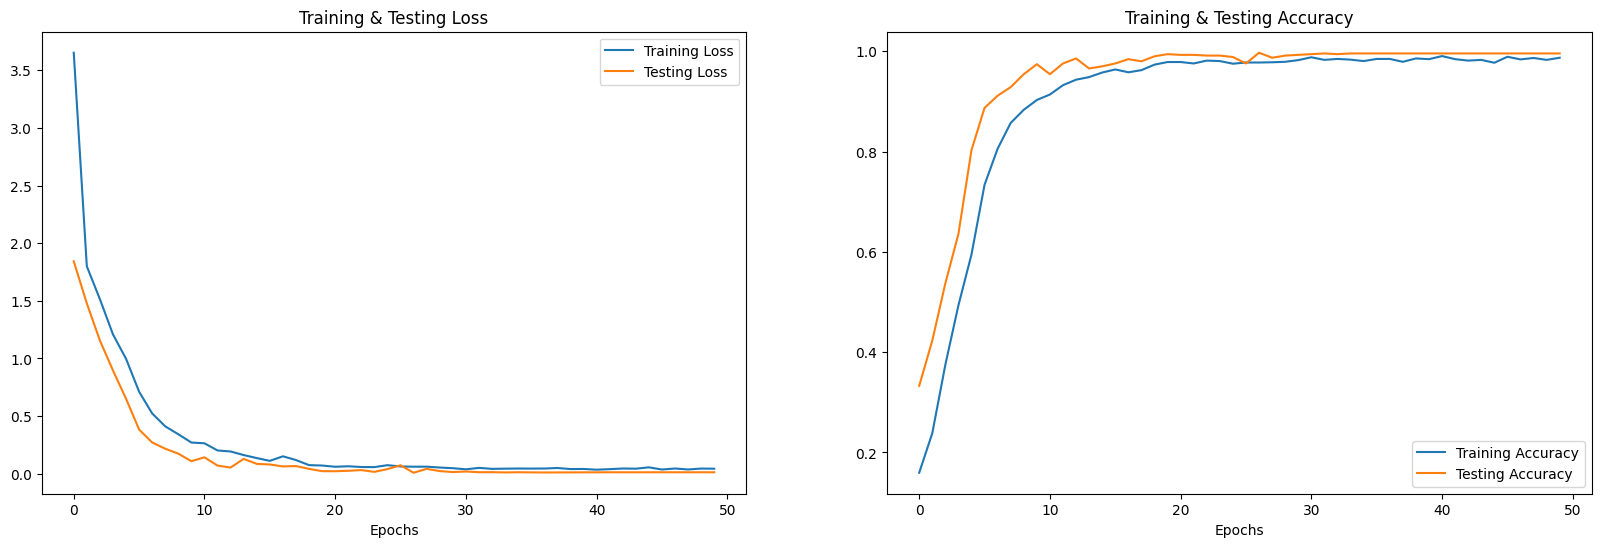

In [75]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

We can see our model is more accurate in predicting surprise, angry emotions and it makes sense also because audio files of these emotions differ to other audio files in a lot of ways like pitch, speed etc..
We overall achieved 99% accuracy on our test data and its decent but we can improve it more by applying more augmentation techniques and using other feature extraction methods.

# LSTM Model

In [81]:
model1 = Sequential([
    LSTM(256, return_sequences=False, input_shape=(40,1)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(7, activation='softmax')
])

model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 256)               264192    
                                                                 
 dropout_14 (Dropout)        (None, 256)               0         
                                                                 
 dense_14 (Dense)            (None, 128)               32896     
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 64)                8256      
                                                                 
 dropout_16 (Dropout)        (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 7)               

In [85]:

history1 = model1.fit(X, y, validation_split=0.2, epochs=50, batch_size=64)

Epoch 1/50
35/35 [==============================] - 9s 168ms/step - loss: 1.0248 - accuracy: 0.5955 - val_loss: 2.9280 - val_accuracy: 0.1696
Epoch 2/50
35/35 [==============================] - 7s 198ms/step - loss: 0.4825 - accuracy: 0.8188 - val_loss: 1.8760 - val_accuracy: 0.2946
Epoch 3/50
35/35 [==============================] - 7s 188ms/step - loss: 0.3148 - accuracy: 0.8946 - val_loss: 2.5589 - val_accuracy: 0.3518
Epoch 4/50
35/35 [==============================] - 7s 203ms/step - loss: 0.1496 - accuracy: 0.9589 - val_loss: 1.3669 - val_accuracy: 0.6643
Epoch 5/50
35/35 [==============================] - 7s 213ms/step - loss: 0.1429 - accuracy: 0.9616 - val_loss: 2.1899 - val_accuracy: 0.5643
Epoch 6/50
35/35 [==============================] - 8s 228ms/step - loss: 0.1317 - accuracy: 0.9580 - val_loss: 1.6795 - val_accuracy: 0.6089
Epoch 7/50
35/35 [==============================] - 6s 169ms/step - loss: 0.1715 - accuracy: 0.9460 - val_loss: 0.9900 - val_accuracy: 0.7571
Epoch 

22/22 [==============================] - 1s 36ms/step - loss: 0.8708 - accuracy: 0.8871
Accuracy of our model on test data :  88.71428370475769 %


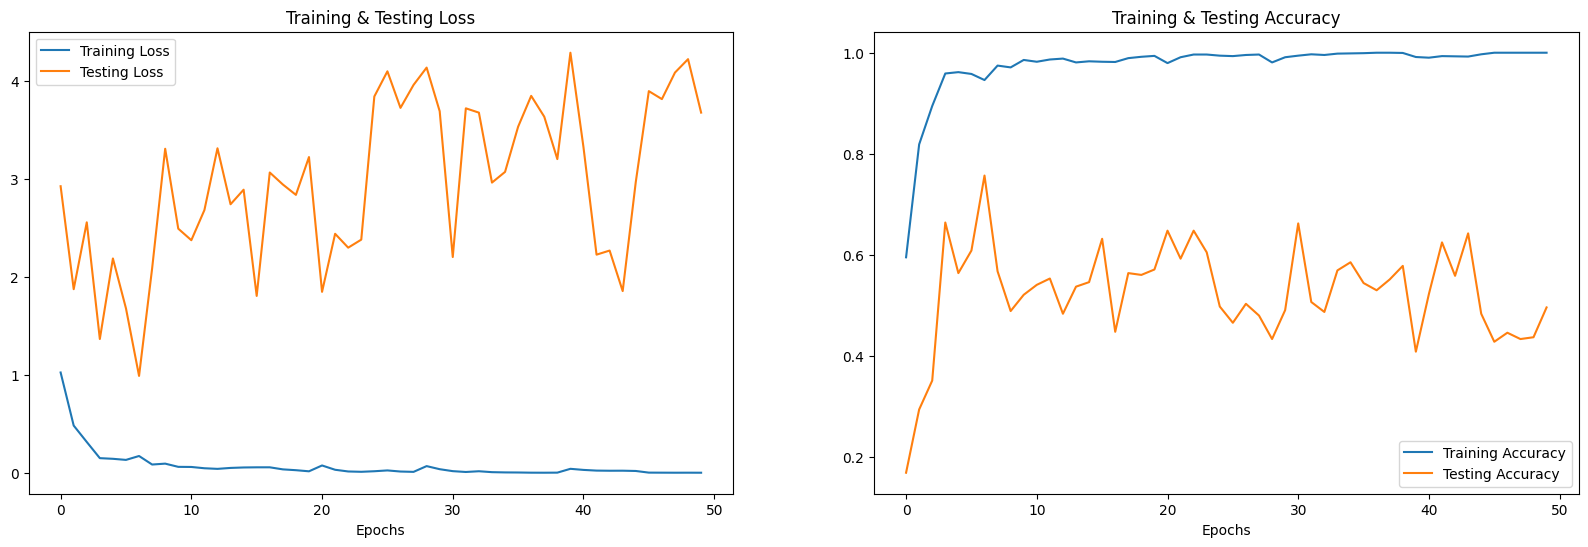

In [86]:
print("Accuracy of our model on test data : " , model1.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history1.history['accuracy']
train_loss = history1.history['loss']
test_acc = history1.history['val_accuracy']
test_loss = history1.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

The training process resulted in a promising best validation accuracy of 88.71%. To ensure that we preserve this optimal model for future use, a checkpoint mechanism was employed to save the model associated with the highest validation accuracy. This safeguard ensures that we can access the best-performing model even if subsequent iterations do not surpass this threshold.

Moreover, to enhance training efficiency and promote convergence, the learning rate was dynamically adjusted. By monitoring the training progress, adjustments to the learning rate were made to prevent stagnation or overshooting of the optimal solution. This adaptive learning rate strategy optimizes the training process, allowing the model to efficiently navigate the parameter space and converge towards an optimal solution.